In [36]:
import pandas as pd
import tensorflow as tf
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

plt.style.use('fivethirtyeight')

In [37]:
df=pd.read_csv(r"C:\Users\nithi\Downloads\nlpdataset.csv",encoding='latin1')

In [38]:
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [36]:
df.shape

(1048575, 4)

In [37]:
df.head

<bound method NDFrame.head of           Sentence #           Word  POS Tag
0        Sentence: 1      Thousands  NNS   O
1                NaN             of   IN   O
2                NaN  demonstrators  NNS   O
3                NaN           have  VBP   O
4                NaN        marched  VBN   O
...              ...            ...  ...  ..
1048570          NaN           they  PRP   O
1048571          NaN      responded  VBD   O
1048572          NaN             to   TO   O
1048573          NaN            the   DT   O
1048574          NaN         attack   NN   O

[1048575 rows x 4 columns]>

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048565 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [39]:
df['Tag'].value_counts()

Tag
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64

In [40]:
df.isnull().sum()

Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

In [41]:
df = df.fillna(method='ffill')

In [42]:
df.isnull().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [43]:
df.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [44]:
print('unique words in corpus: ',df['Word'].nunique())
print('unique tags in corpus: ',df['Tag'].nunique())

unique words in corpus:  35177
unique tags in corpus:  17


In [48]:
words = list(set(df['Word'].values))
words.append('ENDPAD')
num_words = len(words)
print("Number of words:",num_words)
tags = list(set(df['Tag'].values))
num_tags = len(tags)
print("Number of Tags:",num_tags)

Number of words: 35178
Number of Tags: 17


In [49]:
class SentenceGetter(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s:[(w,p,t) for w,p,t in zip(s['Word'].values.tolist(),
                                                     s['POS'].values.tolist(),
                                                     s['Tag'].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [50]:
getter = SentenceGetter(df)
sentences = getter.sentences

In [51]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

In [52]:
word2idx = {w: i+1 for i,w in enumerate(words)}
tag2idx = {t: i for i,t, in enumerate(tags)}
word2idx

{'1715': 1,
 'Etienne': 2,
 'wolf': 3,
 'enroute': 4,
 'Emmerick': 5,
 'Sprem': 6,
 'Khanty-Mansiisk': 7,
 'lessen': 8,
 'Chopan': 9,
 'enormous': 10,
 'undemocratic': 11,
 'Giro': 12,
 'formality': 13,
 'Tookie': 14,
 'streaming': 15,
 'lakes': 16,
 'militarized': 17,
 'Jane': 18,
 'really': 19,
 'Warden': 20,
 'H5-type': 21,
 'seed': 22,
 'Physically': 23,
 'transmissions': 24,
 'circle': 25,
 'Aryanto': 26,
 'declared': 27,
 'Coahuila': 28,
 'Ponting': 29,
 'Cuban-engineered': 30,
 'unconcern': 31,
 'Escape': 32,
 'unconditional': 33,
 'Enterprise': 34,
 'remind': 35,
 'Normally': 36,
 'exemption': 37,
 'Psychiatrist': 38,
 'jog': 39,
 'underfunded': 40,
 'dance': 41,
 'fibroid': 42,
 'Institute': 43,
 'Annunciation': 44,
 'seeks': 45,
 'Kush': 46,
 'affiliate': 47,
 '2.8': 48,
 'BEN': 49,
 'rebate': 50,
 'M-1': 51,
 'Ugandans': 52,
 'depression': 53,
 'Mazda': 54,
 'Foreign': 55,
 '2,711': 56,
 'tactical': 57,
 'Westinghouse': 58,
 'spilling': 59,
 'were': 60,
 'Shahr-e-Kord': 61,


In [54]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences = X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences = y, padding='post', value=tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [55]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=1)

In [56]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758900   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           120800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 17)            3417      
 ributed)                                                        
                                                             

In [57]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [58]:
X_train.shape,np.array(y_train).shape

((43163, 50), (43163, 50, 17))

In [59]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2,verbose=0, mode='max', restore_best_weights = False)
callbacks = [early_stopping]

history = model.fit(
    X_train,np.array(y_train),
    validation_split=0.2,
    batch_size = 64,
    epochs = 5,
    verbose=2
)

Epoch 1/5
540/540 - 208s - loss: 0.2689 - accuracy: 0.9423 - val_loss: 0.1213 - val_accuracy: 0.9654 - 208s/epoch - 385ms/step
Epoch 2/5
540/540 - 196s - loss: 0.0779 - accuracy: 0.9782 - val_loss: 0.0611 - val_accuracy: 0.9825 - 196s/epoch - 364ms/step
Epoch 3/5
540/540 - 207s - loss: 0.0479 - accuracy: 0.9861 - val_loss: 0.0521 - val_accuracy: 0.9845 - 207s/epoch - 384ms/step
Epoch 4/5
540/540 - 201s - loss: 0.0382 - accuracy: 0.9886 - val_loss: 0.0503 - val_accuracy: 0.9850 - 201s/epoch - 373ms/step
Epoch 5/5
540/540 - 206s - loss: 0.0326 - accuracy: 0.9900 - val_loss: 0.0498 - val_accuracy: 0.9852 - 206s/epoch - 382ms/step


In [60]:
model.evaluate(X_test,np.array(y_test))

150/150 [==============================] - 8s 52ms/step - loss: 0.0507 - accuracy: 0.9851


[0.05070751532912254, 0.9851459264755249]

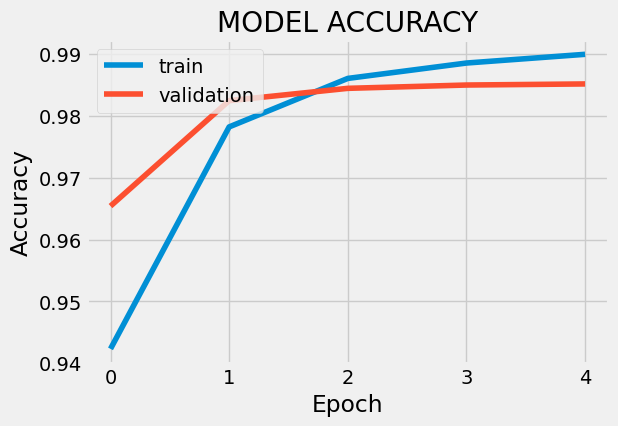

In [71]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MODEL ACCURACY')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

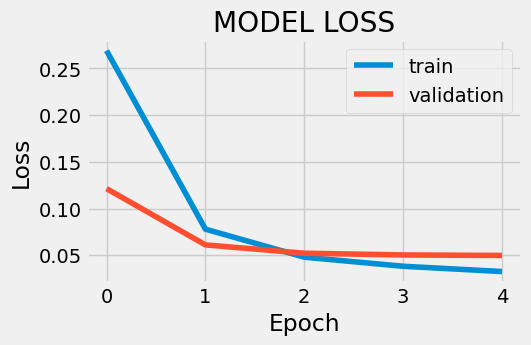

In [68]:
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MODEL LOSS')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


training_texts = [
    "Apple Inc. is planning to launch a new product next month.",
    "Microsoft announced its quarterly earnings report.",
    "Tesla's stock price reached an all-time high.",
    "The European Central Bank is considering an interest rate hike."
]
fine_grained_labels = ["ORG", "ORG", "STOCK", "ORG"]


tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(training_texts)


logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, fine_grained_labels)


prediction_texts = [
    "Apple is set to announce its latest product at the upcoming event.",
    "Amazon's stock price saw significant growth this quarter."
]


X_prediction = tfidf_vectorizer.transform(prediction_texts)


predictions = logistic_regression_model.predict(X_prediction)

print("Predicted fine-grained entities:", predictions)


In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [25]:
training_texts = [
    "Apple Inc. is planning to launch a new product next month.",
    "Microsoft announced its quarterly earnings report.",
    "Tesla's stock price reached an all-time high.",
    "The European Central Bank is considering an interest rate hike."
    
]
fine_grained_labels = ["ORG", "ORG", "STOCK", "ORG"]

In [26]:
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(training_texts)

In [27]:
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, fine_grained_labels)

LogisticRegression()

In [28]:
prediction_texts = [
    "Apple is set to announce its latest product at the upcoming event.",
    "Amazon's stock price saw significant growth this quarter."
]

In [29]:
X_pred = tfidf_vectorizer.transform(prediction_texts)

In [30]:
predictions = logistic_regression_model.predict(X_pred)

print("Predicted fine-grained entities:", predictions)

Predicted fine-grained entities: ['ORG' 'ORG']


In [31]:
rf = RandomForestClassifier()
rf.fit(X_train, fine_grained_labels)

RandomForestClassifier()

In [32]:
predictions = rf.predict(X_pred)

print("Predicted fine-grained entities:", predictions)

Predicted fine-grained entities: ['ORG' 'ORG']


In [33]:
from sklearn.metrics import accuracy_score, precision_score
true_labels=fine_grained_labels
predicted_labels = logistic_regression_model.predict(X_train)
print(predicted_labels)

['ORG' 'ORG' 'ORG' 'ORG']


In [34]:
from sklearn.metrics import accuracy_score
a = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {a*100}")

Accuracy: 75.0
